# bayesloop tutorial

This notebook is designed to provide a step-by-step guide describing the main features of [*bayesloop*](http://christophmark.github.io/bayesloop/). The tutorial is mainly based on a real-world data set that has been studied extensively in the literature (see this [article](http://www.dima.unige.it/~riccomag/Teaching/ProcessiStocastici/coal-mining-disaster-original%20paper.pdf), or the [PyMC tutorial](https://pymc-devs.github.io/pymc/tutorial.html)). It consists of the annual number of coal mining disasters in the United Kingdom from 1851 to 1962.

**Contents**
1. [Basic data study](#section_1)<br>
  1.1 [Study class](#section_1.1)<br>
  1.2 [Data import](#section_1.2)<br>
  1.3 [Observation model](#section_1.3)<br>
  1.4 [Transition model](#section_1.4)<br>
  1.5 [Parameter grid](#section_1.5)<br>
  1.6 [Model fit](#section_1.6)<br>
  1.7 [Plotting](#section_1.7)<br>
2. [Model selection](#section_2) (TODO)<br>
  2.1 [Bayes factor](# section_2.1)<br>
  2.2 [Combined transition models](# section_2.2)<br>
3. [Model optimization](#section_3)
4. [Change-point study](#section_4)
5. [Online study](#section_5)

<a id='section_1'></a>
## 1. Basic data study
The first section of the tutorial introduces the main class of the module, `Study`. We provide a detailed description of how to import data, set the observation model and transition model, specify the parameter grid and perform the model fit. Finally, a plotting function to display the results is discussed briefly.

<a id='section_1.1'></a>
### 1.1 Study class
To start a new data study/analysis, create a new instance of the `Study` class:

In [1]:
import bayesloop as bl

S = bl.Study()

+ Created new study.


This object is central to an analysis conducted with *bayesloop*. It stores the data and further provides the methods to perform probabilistic inference on the models defined within the class, as described below.

<a id='section_1.2'></a>
### 1.2 Data import
In this first study, we use a simple, yet instructive example of heterogeneous time series, the annual number of coal mining accidents in the UK from 1851 to 1962. The data is imported as a NumPy array:

In [2]:
import numpy as np

data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

S.loadData(data)

+ Successfully imported array.


Note that this particular data set is also hard-coded into the `Study` class, for convenient testing:

In [3]:
S.loadExampleData()

+ Successfully imported example data.


In case you have multiple observations for each time step, you may also provide the data in the form `np.array([[x1,y1,z1], [x2,y2,z2], ..., [xn,yn,zn]])`. Missing data points should be included as `np.nan`.

<a id='section_1.3'></a>
### 1.3 Observation model
The first step to create a probabilistic model to explain the data is to define the **observation model**, or **likelihood**. The observation model states the probability (density) of a data point at time $t$, given the parameter values at time $t$ and possibly past data points.

As coal mining disasters fortunately are rare events, we may model the number of accidents per year by a [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution (data from subsequent years is assumed to be uncorrelated):

In [4]:
M = bl.observationModels.Poisson()
S.setObservationModel(M)

+ Observation model: Poisson


Note that you can also use the following short form to define observation models: `M = bl.om.Poisson()`. All currently implemented observation models can be looked up in `observationModels.py`.

<a id='section_1.4'></a>
### 1.4 Transition model
As the dynamics of many real-world systems are the result of a multitude of underlying processes that act on different spatial and time scales, common statistical models with static parameters often miss important aspects of the systems' dynamics (see e.g. this [article](http://www.nature.com/articles/ncomms8516)). *bayesloop* therefore calls for a second model, the **transition model**, which describes the temporal changes of the model parameters.

As stated above, we model the observed data by a Poisson distribution with one parameter, the rate $\lambda$ (directly decribing the average number of disasters per year). You can retrieve a list of parameters from the chosen observation model:

In [5]:
M.parameterNames

['lambda']

In this example, we assume that $\lambda$ itself may change gradually over time and choose a Gaussian random walk with the standard deviation $\sigma=0.2$ as transition model. The value of the Hyper-parameter $\sigma$ is set from the beginning, but can be optimized (see [Sect. 3](#section_3)).

In [6]:
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)

+ Transition model: Gaussian random walk


Note that you can also use the following short form to define transition models: `M = bl.tm.GaussianRandomWalk()`. All currently implemented transition models can be looked up in `transitionModels.py`.

<a id='section_1.5'></a>
### 1.5 Parameter grid
While many inference algorithms designed for hierarchical time series analysis rely on [MCMC](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf) techniques, *bayesloop* chooses a grid-based approach. All probability distributions are discretized on a regular grid of parameter values. While this approach restricts the choice of observation models to those with only few parameters, it allows to perform very fast probabilistic inference, model selection and model optimization.

The parameter grid has be configured prior to calling any fit- or optimization-routine. First, the grid size has to be set for each parameter (here, only $\lambda$):

In [7]:
S.setGridSize([1000])

Second, parameter boundaries have to be set. One has to provide a list of lists, where each inner list consists of a lower and an upper boundary value. Note that choosing the boundaries to narrow may negatively affect the outcome of the analysis. In case the inferred parameter values come close to the boundary values, one should consider re-running the analysis with looser boundaries.

In our example, we restrict the annual disaster rate to the interval $[0,6]$. We will see that this is sufficient when plotting the results below.

In [8]:
S.setBoundaries([[0, 6]])

Note that if you do not provide a proper grid size, *bayesloop* will set it automatically to the default value stored in each observation model. In case no parameter boundaries are given, *bayesloop* will offer to set default values. Keep in mind, though, that correct parameter boundaries strongly depend on the data set at hand.

<a id='section_1.6'></a>
### 1.6 Model fit

At this point, the hierarchical time series model for the coal mining data set is properly defined and we may continue to perform the model fit. *bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). The inference algorithm is implemented by the `fit` method:

In [9]:
S.fit()

+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -75.49376
    + Finished backward pass.
    + Computed mean parameter values.


By default, `fit` computes the so-called *smoothing distribution* of the model parameters for each time step. This distribution states the probability (density) of the parameter value at a time step $t$, given all past and future data points. All distributions have the same shape as the parameter grid, and are stored in `S.posteriorSequence` for further analysis. Additionally, the mean values of each distribution are stored in `S.posteriorMeanValues`, as point estimates. Finally, the (natural) logarithmic value of the evidence, the probability of the data given the chosen model, is stored in `S.logEvidence` (see [Sect. 2](#section_2)). 

To simulate an online-analysis, where at each step in time $t$, only past data points are available, one may provide the keyword-argument `forwardOnly=True`. In this case, only the *forward*-part of the algorithm in run. The resulting parameter distributions are called *filtering distributions*.

<a id='section_1.7'></a>
### 1.7 Plotting
To display the temporal evolution of the model parameters, *bayesloop* provides a simple plot function `plotParameterEvolution` that displays the mean values together with its marginal distributions for one parameter of the model. The parameter to be plotted can be chosen by providing an index or the name of the parameter (by default, the first one is plotted).

Here, we plot the original data (in red) together with the inferred disaster rate (mean value in black, marginal distirbution in blue):

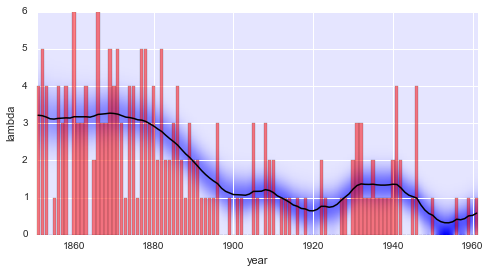

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# plot of raw data
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)

# parameter plot
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)

plt.xlim([1850, 1962])
plt.xlabel('year')

From this first analysis, we may conclude that before $1880$, an average of $\approx 3$ accidents were recorded. This changes significantly between $1880$ and $1900$, when the accident-rate drops to $\approx 1$. Studies like this one may in the future help to objectively quantify the effects of policies, like safety regulations.

<a id='section_2'></a>
## 2 Model Selection

In Bayesian statistics, an objective model comparison is carried out by comparing the models' [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood). The likelihood function describes the probability (density) of the data, given the parameter values (and thereby the chosen model). By integrating out (marginalizing) the parameter values, one obtains the marginal likelihood (or model evidence), which directly measures the fitness of the model at hand. The model evidence represents a powerful tool for model selection, as it does not assume specific distributions (e.g. [Student's t-test](https://en.wikipedia.org/wiki/Student's_t-test) assumes Gaussian distributed variables) and automatically follows the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor).

The forward-backward algorithm that *bayesloop* relies on allows to approximate the marginal likelihood based on the discretized parameter distributions. Details on this method in the context of Hidden Markov models can be found [here](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf).

This section aims at giving a very brief introduction of Bayes factors together with an example based on the coal mining data and further introduces combined transition models in *bayesloop*.

<a id='section_2.1'></a>
### 2.1 Bayes factor

Instead of interpreting the value of the marginal likelihood for a single model, it is common to compare two competing models/explanations $M_1$ and $M_2$ by evaluating the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor), here denoted as $B_{12}$. The Bayes factor is given by the ratio of the two marginal likelihood values:

$$B_{12} = \frac{p(D|M_1)}{p(D|M_2)}$$

where $p(D|M_i)$ states the probability of the data (marginal likelihood) given model $M_i$. A value of $B_{12} > 1$ therefore indicates that the data is better explained by model $M_1$, compared to $M_2$. More detailed information for the interpretation of the value of Bayes factors can be found [here](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) and in the references therein.

As a first example, we investigate whether the inferred disaster rate of the coal mining data set indeed should be modeled as a time-varying parameter (a constant rate is an equally valid hypothesis). We first fit the model using the `GaussianRandomWalk` model with a standard deviation of $\sigma = 0.2$ (shown in the plot in [Sect. 1.7](#section_1.7)) to determine the corresponding marginal likelihood (on a log scale). Subsequently, we use the simpler `Static` transition model (assuming no change of the disaster rate over time) and compare the resulting marginal likelihood by computing the Bayes factor. Note that for computational efficiency, the keyword argument `evidenceOnly=True` is used, which evaluates the model evidence, but does not store any results for plotting.

In [11]:
# dynamic disaster rate
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)
S.fit(evidenceOnly=True)

dynamicLogEvidence = S.logEvidence

#static disaster rate
K = bl.transitionModels.Static()
S.setTransitionModel(K)
S.fit(evidenceOnly=True)

staticLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence - staticLogEvidence)
print '\nBayes factor: B =', B

+ Transition model: Gaussian random walk
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -75.49376
+ Transition model: Static/constant parameter values
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -89.07363

Bayes factor: B = 3.80078193065e+13


The computed Bayes factor $B = 3.8 \cdot 10^{13}$ shows decisive support for the first hypothesis of a dynamic disaster rate.

While this analysis conducted above clearly rules for a time-varying rate, there may still exist a dynamic model that represents a better fit than the Gaussian random walk with $\sigma=0.2$. A very simple dynamic model is given by the transition model `ChangePoint` that assumes an abrupt change of the disaster rate at a predefined point in time, we choose $1891$ here. Note that we perform a full fit in this case, as we want to provide a plot of the result:

+ Transition model: Change-point model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -75.20160
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 1.95956358558


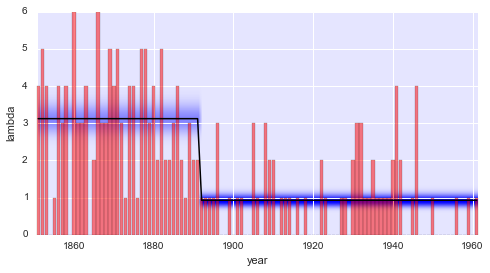

In [27]:
# dynamic disaster rate (change-point model)
K = bl.transitionModels.ChangePoint(tChange=40)  # the 41nd data point (index 40) corresponds to 1891
S.setTransitionModel(K)
S.fit()

dynamicLogEvidence2 = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence2 - dynamicLogEvidence)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

The Bayes factor shows support in favor of the change-point model, compared to the Gaussian random walk model. However, the relatively low value of $B = 1.96$ indicates only weak support and is [not worth more than a bare mention](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation). Based on the data at hand, no clear decision between the two models can be made. While the change-point model is favored because it is more restricted (the number of possible data sets that can be decribed by this model is much smaller than for the Gaussian random walk) and therefore *"simpler"*, it cannot capture fluctuations of the disaster rate before and after $1891$ like the Gaussian random walk model does.

<a id='section_2.2'></a>
### 2.2 Combined transition models

The discussion above shows that depending on the data set, different transition models better explain different aspects of the data. For some data sets, a satisfactory transition model may only be found by combining several simple transition models. *bayesloop* provides a transition model class called `CombinedTransitionModel` that can be supplied with a sequence of transition models that are subsequently applied at every time step. Here, we combine the change-point model and the Gaussian random walk model to check whether the combined model yields a better explanation of the data, compared to the change-point model alone:

+ Transition model: Combined transition model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -74.90471
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 1.98102427873


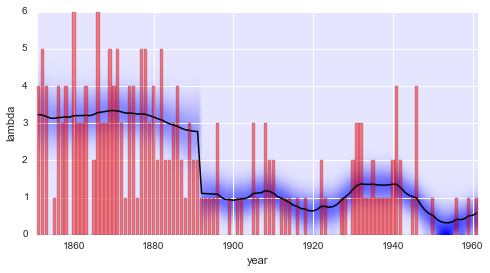

In [31]:
# combined model (change-point model + Gaussian random walk)
K = bl.transitionModels.CombinedTransitionModel(bl.transitionModels.ChangePoint(tChange=40),
                                                bl.transitionModels.GaussianRandomWalk(sigma=0.2))
S.setTransitionModel(K)
S.fit()

combinedLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(combinedLogEvidence - dynamicLogEvidence2)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

Again, the refined model is favored by a Bayes factor of $B = 1.98$. However, the gain in evidence compared to the change-point model is [not worth more than a bare mention](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation).

The iterative approach of creating new hypotheses and comparing them to the best hypothesis currently available provides an objective and never-the-less straight-forward way of exploring new data sets.

<a id='section_3'></a>
## 3 Model optimization

The model evidence cannot only be used to compare different kinds of time series models, but also to optimize the hyper-parameters of a given transition model by maximizing its evidence value. The `Study` class of *bayesloop* contains a method `optimize` which relies on the `minimize` function of the `scipy.optimize` module. Since *bayesloop* has no gradient information about the hyper-parameters, the optimization routine is based on the [COBYLA](https://en.wikipedia.org/wiki/COBYLA) algorithm.

The method supports all currently implemented transition models with continuous hyper-parameters, as well as combinations of multiple models. The change-point model represents an exception here, as its only parameter `tChange` is discrete. See [Sect. 4](#section_4) for further information on change-point studies. In the current implementation of the optimization routine, all hyper-parameters of the transition model are optimized. The option to selectively optimize specific hyper-parameters is planned for a future release of *bayesloop*. The parameter values set by the user when defining the transition model are used as starting values. During optimization, only the log-evidence of the model is computed. When finished, a full fit is done to provide the parameter distributions and mean values for the optimal model setting.

We take up the coal mining example again, and choose a gradually varying disaster rate, i.e. the Gaussian random walk as transition model (with an initial st.dev of $\sigma = 0.2$). This time, however, we optimize the magnitude of change that the disaster rate undergoes, i.e. the standard deviation of the Gaussian random walk:

+ Transition model: Gaussian random walk
+ Starting optimization...
    + Log10-evidence: -75.49376 - Parameter values: [ 0.2]
    + Log10-evidence: -79.82435 - Parameter values: [ 1.2]
    + Log10-evidence: -89.07363 - Parameter values: [-0.8]
    + Log10-evidence: -89.07363 - Parameter values: [-0.3]
    + Log10-evidence: -75.70130 - Parameter values: [ 0.45]
    + Log10-evidence: -78.48146 - Parameter values: [ 0.075]
    + Log10-evidence: -75.27472 - Parameter values: [ 0.2625]
    + Log10-evidence: -75.29974 - Parameter values: [ 0.325]
    + Log10-evidence: -75.26561 - Parameter values: [ 0.29375]
    + Log10-evidence: -75.27801 - Parameter values: [ 0.309375]
    + Log10-evidence: -75.26333 - Parameter values: [ 0.2859375]
    + Log10-evidence: -75.26394 - Parameter values: [ 0.278125]
    + Log10-evidence: -75.26326 - Parameter values: [ 0.28203125]
    + Log10-evidence: -75.26350 - Parameter values: [ 0.28007813]
    + Log10-evidence: -75.26321 - Parameter values: [ 0.28300781

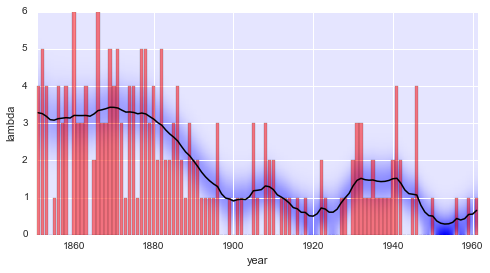

In [12]:
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)

S.optimize()

plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

The optimal value for the standard deviation of the varying disaster rate is determined to be $\approx 0.28$, the initial guess of $\sigma = 0.2$ is therefore too restrictive. The optimal hyper-parameter values are displayed in the output during optimization, but can also be inspected directly:

In [13]:
S.transitionModel.hyperParameters['sigma']

0.28354023437500003

<a id='section_4'></a>
## 4 Change-point study

[Change point analysis](http://www.variation.com/cpa/tech/changepoint.html) or [change detection](https://en.wikipedia.org/wiki/Change_detection) deals with abrupt changes in statistical properties of time series. As introduced in [Sect. 2](#section_2), *bayesloop* includes a change-point transition model that assumes an abrupt change in parameter values at a predefined point in time. With Bayesian evidence as an objective fitness measure, this transition model can be used to answer the more general question of when a change has happened. Furthermore, we may compute a distribution of change-point times to assess the (un-)certainty of this point in time.

*bayesloop* provides the `ChangepointStudy` class that iterates over all possible time steps using the change-point model. After processing all time steps, the probability distribution of the change-point as well as an average model are computed. This study may also be carried out using MCMC methods, see e.g. the [PyMC tutorial](https://pymc-devs.github.io/pymc/tutorial.html) for comparison.

The change-point study is set up as follows:

In [14]:
cpS = bl.ChangepointStudy()
cpS.loadExampleData()

M = bl.om.Poisson()
cpS.setObservationModel(M)

cpS.setGridSize([1000])
cpS.setBoundaries([[0, 6]])

cpS.fit()

+ Created new study.
  --> Change-point study
+ Successfully imported example data.
+ Observation model: Poisson
+ Started new fit.
    + t = 0 -- log10-evidence = -88.80733
    + t = 1 -- log10-evidence = -88.01598
    + t = 2 -- log10-evidence = -87.55673
    + t = 3 -- log10-evidence = -88.52038
    + t = 4 -- log10-evidence = -88.92082
    + t = 5 -- log10-evidence = -88.51469
    + t = 6 -- log10-evidence = -88.35211
    + t = 7 -- log10-evidence = -87.89544
    + t = 8 -- log10-evidence = -88.51773
    + t = 9 -- log10-evidence = -87.52353
    + t = 10 -- log10-evidence = -87.32556
    + t = 11 -- log10-evidence = -87.11994
    + t = 12 -- log10-evidence = -86.59570
    + t = 13 -- log10-evidence = -87.27485
    + t = 14 -- log10-evidence = -87.33393
    + t = 15 -- log10-evidence = -86.22201
    + t = 16 -- log10-evidence = -85.97832
    + t = 17 -- log10-evidence = -85.72664
    + t = 18 -- log10-evidence = -84.79208
    + t = 19 -- log10-evidence = -84.15814
    + t = 20 -- lo

After all fits are completed, we can plot the change-point distribution, by accessing `cpS.changepointDistribution`:

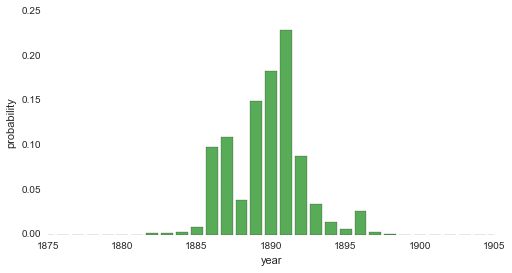

In [15]:
plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), cpS.changepointDistribution, align='center', facecolor='g', alpha=.65)
plt.xlim([1875, 1905])
plt.xlabel('year')
plt.ylabel('probability')

From this distribution, we may conclude that a change in safety conditions of coal mines in the UK happended sometime between $1886$ and $1892$, with a probability of $\approx 90\%$.

*bayesloop* further weighs all fitted models by their probability from the change-point distribution and subsequently adds them up, resulting in an average model, which is stored in `cpS.posteriorSequence` and `cpS.posteriorMeanValues`. Additionally, the log-evidence of the average model is set by the weighted sum of all log-evidence values. These results can be plotted as before, using `plotParameterEvolution`:

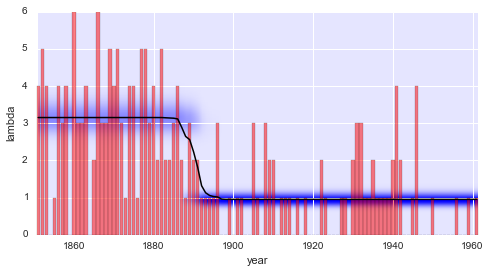

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), cpS.rawData, align='center', facecolor='r', alpha=.5)
bl.plotParameterEvolution(cpS, param='lambda', xLower=1851, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

The change-point study described above explicitely assumes the existience of a single change-point in the data set. Withour any prior knowledge of a certain data set, however, this assumption can rarely be made with certainty as the number of potential change-points is often unknown.

In order to *explore* possible change-points withour prior knowledge, *bayesloop* includes the transition model `RegimeSwitch`, which assigns a minimal probability (specified on a log<sub>10</sub>-scale by `log10pMin`) to all parameter values on the parameter grid at every time step. This model allows for abrupt parameter changes only, and neglects gradually varying parameter dynamics.

For the coal mining example, the results from the regime-switching model with a minimal probability of $10^{-7}$ resemble the average model of the change-point study:

+ Transition model: Regime-switching model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -79.19799
    + Finished backward pass.
    + Computed mean parameter values.


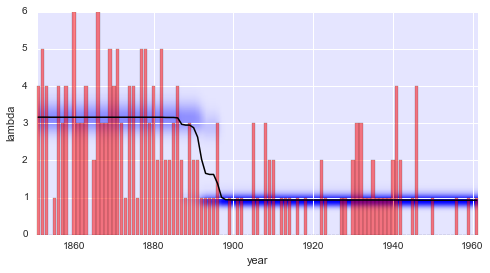

In [17]:
K = bl.transitionModels.RegimeSwitch(log10pMin=-7)
S.setTransitionModel(K)

S.fit()

plt.figure(figsize=(8, 4))
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

<a id='section_5'></a>
## 5. Online study

For some applications, one is not necessarily interested in past parameter values, but instead needs a re-evaluation of the current parameter values as new data becomes available. *bayesloop* provides the `OnlineStudy` class to handle the analysis of live data streams. This class includes a `step` method that performs a single inference step based on one new data point. While only the current parameter distribution and mean values are stored, the class stores all data points for later analysis.

To provide an example for the usage of the `step` method, we iterate over all data points from the coal mining data set and subsequently plot the parameter distribution of the last year, $1962$.

In [18]:
data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

oS = bl.OnlineStudy()

M = bl.om.Poisson()
oS.setObservationModel(M)

K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
oS.setTransitionModel(K)

oS.setGridSize([1000])
oS.setBoundaries([[0, 6]])

for d in data:
    oS.step(d)

+ Created new study.
  --> Online study
+ Observation model: Poisson
+ Transition model: Gaussian random walk
    + Initialized flat prior distribution.
    + Updated posterior distribution. Data points: 1; Local evidence: 0.1192
    + Updated posterior distribution. Data points: 2; Local evidence: 0.1301
    + Updated posterior distribution. Data points: 3; Local evidence: 0.1727
    + Updated posterior distribution. Data points: 4; Local evidence: 0.0211
    + Updated posterior distribution. Data points: 5; Local evidence: 0.1307
    + Updated posterior distribution. Data points: 6; Local evidence: 0.1454
    + Updated posterior distribution. Data points: 7; Local evidence: 0.2039
    + Updated posterior distribution. Data points: 8; Local evidence: 0.1597
    + Updated posterior distribution. Data points: 9; Local evidence: 0.0492
    + Updated posterior distribution. Data points: 10; Local evidence: 0.0442
    + Updated posterior distribution. Data points: 11; Local evidence: 0.208

The resulting posterior distribution of the online study is stored in `oS.posteriorDistribution`, the mean value in `oS.posteriorMeanValue`:

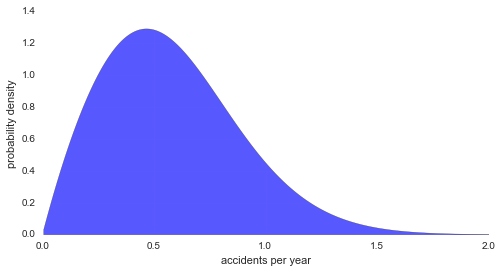

In [19]:
x = oS.grid[0]  # grid points for first (and only) parameter
y = oS.posteriorDistribution  # post. distr. is 1-dimensional in this case

y /= np.prod(oS.latticeConstant)  # normalize by grid-constant to get pdf instead of probability

plt.figure(figsize=(8,4))
plt.fill_between(x, 0, y, facecolor='b', alpha=.65)
plt.xlim([0, 2])
plt.xlabel('accidents per year')
plt.ylabel('probability density')

Apart from the `step` method, the `onlineStudy` class provides two additional methods to control online analyses. The `reset` method resets the current posterior distribution, posterior mean values and log-evidence. The `update` method can be called to re-evaluate the complete data set in the same way as the `step` method would. Note that the `fit` and `optimize` method are inherited from the `Study` class and may also be called within the online study.